## MLP Assignment 02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
# Device configuration
if torch.cuda.is_available():
 device = torch.device('cuda')
else:
 device = torch.device('cpu')
print('device:', device)

device: cuda


#### Step 1) 함수를 생성한다.

In [3]:
'''
 # function_2d
 # Input : x , y
 # output : z = f(x,y)
'''
def function_2d(x,y):
 term_sqrt = np.sqrt(x*x+y*y)
 term1 = np.sin(20*term_sqrt)/(20*term_sqrt)
 term2 = (1/5)*np.cos(10*term_sqrt)
 term3 = y/2 - 0.3
 label = term1 + term2 + term3
 return label
'''
 # generate_data
 # input : dim (int)
 # output : (10000, 3) dataset, type : np.array
 - first column : x
 - second column : y
 - third column : f(x,y) (True label)
'''
def generate_data(dim):
 x = np.linspace(-1, 1, dim)
 y = np.linspace(-1, 1, dim)
 xx, yy = np.meshgrid(x,y)
 zz = function_2d(xx,yy)
 data_1 = xx.reshape(-1,1)
 data_2 = yy.reshape(-1,1)
 label = zz.reshape(-1,1)
 dataset = np.hstack((data_1, data_2))
 dataset = np.hstack((dataset, label))
 return dataset

In [4]:
class Mydataset(torch.utils.data.Dataset):

  def __init__(self, dataX_np , dataY_np):
    self.data_X = dataX_np.astype(np.float32)
    self.data_Y = dataY_np.astype(np.float32)
    print(f"My_dataset __init__ received : {self.data_X.shape}, {self.data_Y.shape} ")

  def __getitem__(self, index):
    batch = self.data_X[index]
    target = self.data_Y[index]
    return batch, target
    
  def __len__(self):
    return len(self.data_X) 

#### Step 2) data point를 10,000개 생성한 뒤, sample_data(x, y)와 target_data(f(x, y))를 생성한다.


In [5]:
dataset = generate_data(100)

x = dataset[:, :2] # sample_data, (10,000 * 2)
y = dataset[:,2:] # target_data, (10,000 * 1)

#### Step 3) Train data, Validation data, Test data로 0.7:0.15:0.15의 비율로 나눈다.

In [6]:
# train-temp 분리 (7:3)
x_train, x_temp, y_train, y_temp = train_test_split(x,y,test_size=0.3, shuffle=True)

# temp 에서 validation-test 분리 3 -> 1.5:1.5
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,shuffle=True)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_test.shape)

(7000, 2)
(1500, 2)
(1500, 2)
(1500, 1)


#### Step 4) DataLoader를 이용하여 데이터를 Shuffle하고 BGD(Batch Gradient Descent)로 활용할 수 있는 학습데이터를 생성한다.

In [7]:
batch_size = 1000000
train_loader = torch.utils.data.DataLoader(Mydataset(x_train, y_train), batch_size=batch_size, shuffle=True, drop_last = False)
valid_loader = torch.utils.data.DataLoader(Mydataset(x_val, y_val), batch_size=batch_size, shuffle=True, drop_last = False)
test_loader = torch.utils.data.DataLoader(Mydataset(x_test, y_test), batch_size=batch_size, shuffle=True, drop_last = False)

My_dataset __init__ received : (7000, 2), (7000, 1) 
My_dataset __init__ received : (1500, 2), (1500, 1) 
My_dataset __init__ received : (1500, 2), (1500, 1) 


#### Step 5) 최소 1개의 Hidden layer를 가진 MLP와, Train 구현  

Input dimension은 2(x와 y), 최종 output
dimension은 1 (예측된 f(x,y))이다. Hidden layer의 뉴런 수는 최소 56개 이상이다.

Model 구현

In [8]:
class SimpleMLP(nn.Module):
  def __init__(self, inp_ = 2, output_ = 1):
    super(SimpleMLP, self).__init__()
    self.fc1 = nn.Linear(inp_, 56)
    self.fc2 = nn.Linear(56, 56)
    self.fc3 = nn.Linear(56, output_)

  def forward(self, x):
    x = self.fc1(x)
    x = F.tanh(x)
    x = self.fc2(x)
    x = F.tanh(x)
    x = self.fc3(x)

    return x

Train 구현

In [9]:
from statistics import mean
import time
def train(model, criterion_, optimizer_, scheduler_, num_epochs=40, first_epoch=1):

  train_losses = []
  valid_losses = []
  test_losses = []
  print("----------------------------------------------------------------------------")
  start_time = time.time()
  for epoch in range(first_epoch, first_epoch + num_epochs):
  
    # train phase
    model.train()

    # batch_loss
    batch_losses = []
    for samples, labels in train_loader:

      # Move the training data to the GPU
      samples = samples.to(device)
      labels = labels.to(device)
      # clear previous gradient computation
      optimizer_.zero_grad()
      # forward propagation
      outputs = model(samples)
      # calculate the loss
      loss = criterion_.forward(outputs, labels)
      batch_losses.append(loss.item())
      # backpropagate to compute gradients
      loss.backward()
      # update model weights
      optimizer_.step()

    # Train loss 를 저장합니다.
    train_losses.append(mean(batch_losses))
    
    # validation phase
    # Dropout, BatchNormalization 과 같은 layer 가 동작하지 않도록 합니다.
    model.eval()
    
    # We don't need gradients for test, so wrap in
    # no_grad to save memory
    # 기울기 Gradient 를 계산하지 않으며 backpropagation 을 하지 않습니다.
    with torch.no_grad():

      for samples, labels in valid_loader:

        # Move the training batch to the GPU
        samples = samples.to(device)
        labels = labels.to(device)

        # forward propagation
        outputs = model(samples)

        # calculate the loss
        loss = criterion_(outputs, labels)
        valid_losses.append(loss.item())

      for samples, labels in test_loader:

        # Move the training batch to the GPU
        samples = samples.to(device)
        labels = labels.to(device)
        
        # forward propagation
        outputs = model(samples)
        
        # calculate the loss
        loss = criterion_(outputs, labels)
        test_losses.append(loss.item())
  
    # 원하는 Epoch 마다 결과 출력
    if (epoch) % 1000== 0 :
      curr_time = round(time.time()-start_time)
      train_rec = round(train_losses[-1],5)
      valid_rec = round(valid_losses[-1],5)
      test_rec = round(test_losses[-1],5)
      print('Epoch', epoch, ' / ',num_epochs)
      print(f"\t [Train loss : {train_rec}] [Validation loss : {valid_rec}][Test loss : {test_rec}] [curr LR = {scheduler_.get_last_lr()}],[elapsed_time = {curr_time}sec] ")
    
    # Learning rate Scheduling
    # Scheduler 에 따라 learning rate 를 조절합니다.
    scheduler_.step()


  print(f"\nTrain Ended, total_elapsed_time = {round(time.time()-start_time)} ")
  print("--------------------------------------------------------------------")

  # Loss 값 반환
  return train_losses, valid_losses, test_losses

Training

In [10]:
model = SimpleMLP()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=10000)

----------------------------------------------------------------------------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 1000  /  10000
	 [Train loss : 0.01362] [Validation loss : 0.01283][Test loss : 0.01404] [curr LR = [0.1]],[elapsed_time = 109sec] 
Epoch 2000  /  10000
	 [Train loss : 0.01306] [Validation loss : 0.00754][Test loss : 0.0075] [curr LR = [0.1]],[elapsed_time = 223sec] 
Epoch 3000  /  10000
	 [Train loss : 0.00123] [Validation loss : 0.00112][Test loss : 0.00123] [curr LR = [0.05]],[elapsed_time = 337sec] 
Epoch 4000  /  10000
	 [Train loss : 0.00267] [Validation loss : 0.0021][Test loss : 0.00235] [curr LR = [0.05]],[elapsed_time = 449sec] 
Epoch 5000  /  10000
	 [Train loss : 0.00074] [Validation loss : 0.00087][Test loss : 0.00095] [curr LR = [0.025]],[elapsed_time = 557sec] 
Epoch 6000  /  10000
	 [Train loss : 0.0007] [Validation loss : 0.00056][Test loss : 0.00065] [curr LR = [0.025]],[elapsed_time = 664sec] 
Epoch 7000  /  10000
	 [Train loss : 0.00035] [Validation loss : 0.00037][Test loss : 0.0004] [curr LR = [0.0125]],[elapsed_time = 769sec] 
Epoch 8000  /  10000
	 [Train

#### Step 7) Plot Loss 함수 정의 및 Plot 그리기

In [11]:
def plot_result(train_loss, val_loss, test_loss):
  plt.figure(figsize=(20,8))
  plt.plot(train_loss, label='Train Loss', linewidth='3')
  plt.plot(val_loss, label='Validation Loss', linewidth='3')
  plt.plot(test_loss, label='Test Loss', linewidth='3')
  plt.grid()
  plt.rc('xtick', labelsize=12)
  plt.rc('ytick', labelsize=12)
  plt.legend()
  plt.rc('legend', fontsize=15)
  plt.xlabel('Number of Epoch')
  plt.ylabel('MSE Loss')

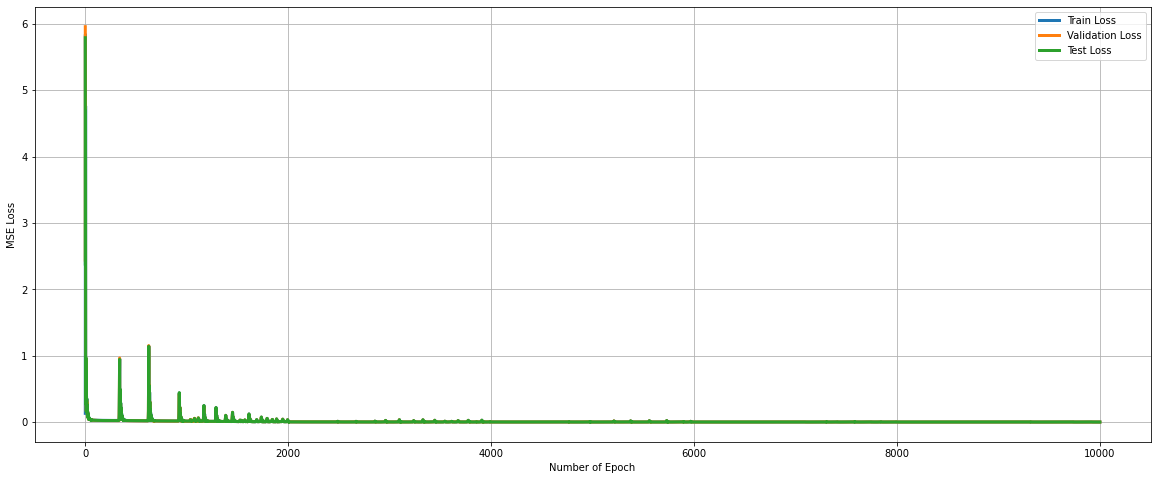

In [12]:
plot_result(train_losses, valid_losses, test_losses)

#### Step 8) 3D visualize graph 정의 및 Plot 그리기

In [13]:
def visual_graph(model):
  x = np.linspace(-1, 1, 100)
  y = np.linspace(-1, 1, 100)
  xx,yy = np.meshgrid(x,y)
  xx = xx.reshape(-1,1)
  yy = yy.reshape(-1,1)
  inp_np = np.hstack((xx,yy))
  inp_tensor = torch.Tensor(inp_np)
  inp_tensor = inp_tensor.to(device)
  zz = model(inp_tensor)
  pred_output = zz.detach().cpu().numpy()
  fig = plt.figure(figsize=(9, 6))
  ax = fig.add_subplot(111, projection='3d')
  xx = xx.reshape(100,100)
  yy = yy.reshape(100,100)
  pred_output = pred_output.reshape(100,100)
  surf = ax.plot_surface(xx, yy, pred_output, cmap='viridis')
  surf.set_clim(-1.0, 1.0)
  ax.view_init(30,-60)
  ax.set_zticks([-1,1])
  ax.zaxis.set_major_locator(ticker.MultipleLocator(0.25))
  plt.tight_layout()
  plt.show()

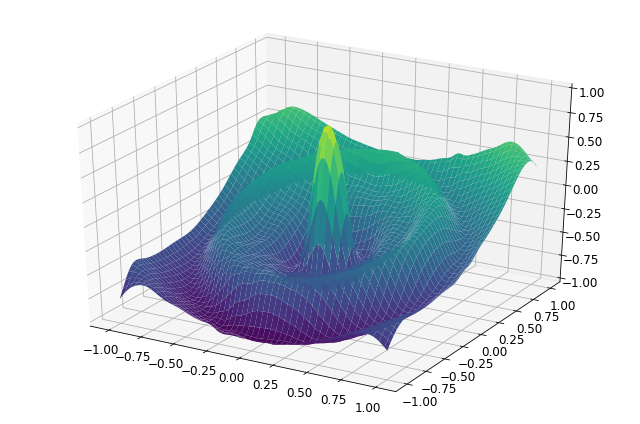

In [14]:
visual_graph(model)